In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot

### EEZ shapes 

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

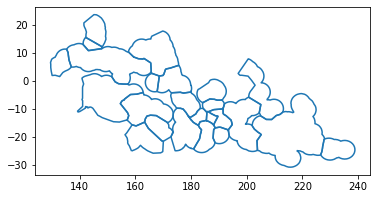

In [9]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [10]:
year = 2021

In [11]:
month = 5

### read the probabilistic forecasts from the GCMs now 

#### list of GCMs to inlude 

In [12]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC']

#### period (`monthly` or `seasonal`)

In [13]:
period = 'monthly'

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [14]:
quantile = 'percentile'

### variable 

In [15]:
varname = 'precip'

### domain 

In [16]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [140, 240, -50, 30],
 'Water_Watch': [120, 240, -38, 22.5]}

In [17]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [18]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [19]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

In [20]:
[f.name for f in lfiles]

['monthly_percentiles_probabilities_from_2021-05_ECCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_CMCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_NCEP.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_UKMO.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_DWD.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_JMA.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_ECMWF.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_METEO_FRANCE.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [21]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

In [22]:
probs

,Array,Chunk
Bytes,69.44 MiB,8.68 MiB
Shape,"(8, 21, 1, 5, 86, 126)","(1, 21, 1, 5, 86, 126)"
Count,24 Tasks,8 Chunks
Type,float64,numpy.ndarray


### look at the sum for each GCM, should sum to 100 

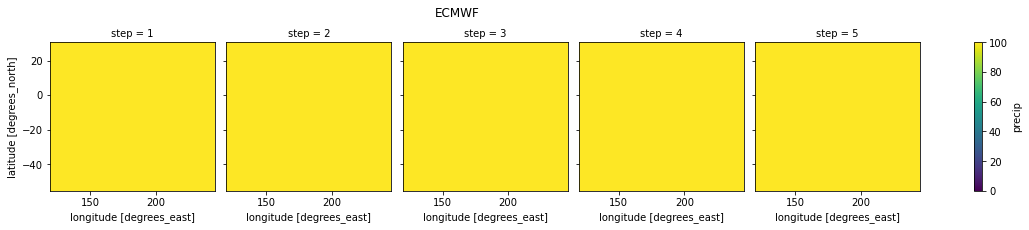

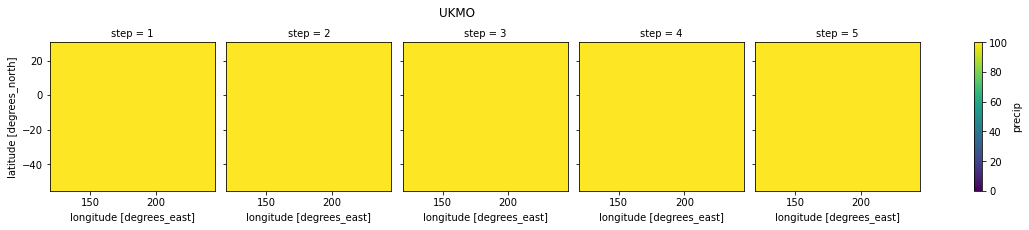

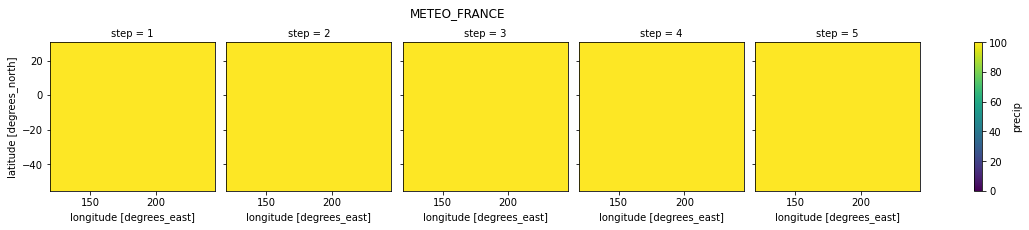

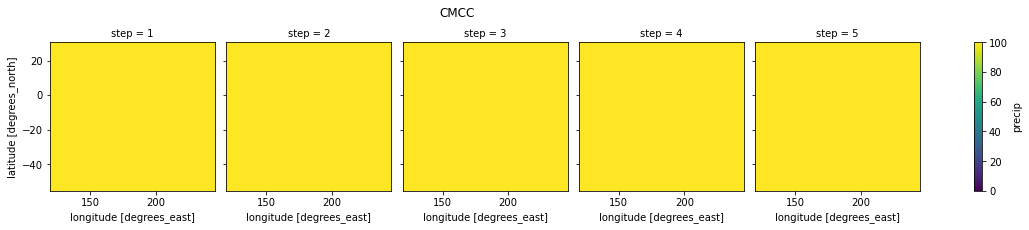

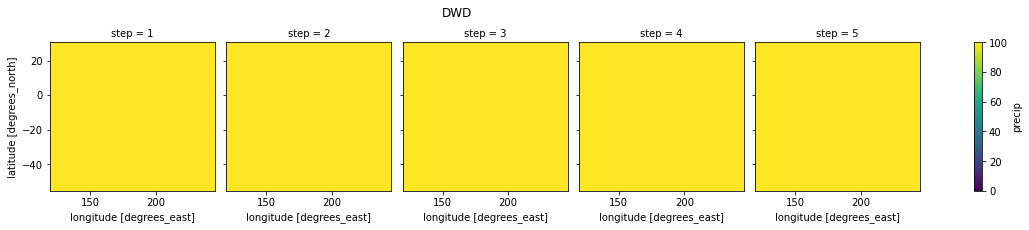

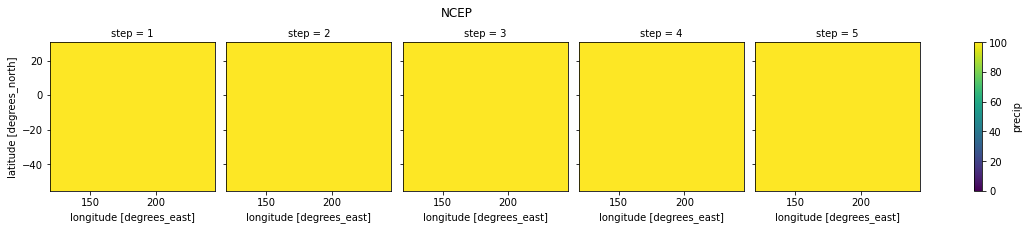

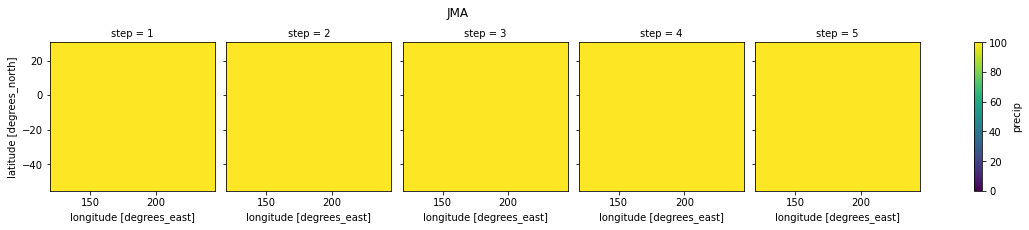

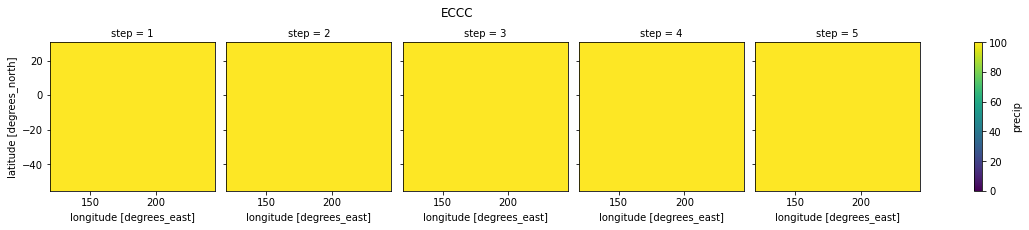

In [23]:
for GCM in list_GCMs:
    fg = probs.sel(GCM=GCM).sum(quantile).squeeze()[varname].plot(col='step', vmin=0);
    fg.fig.suptitle(GCM, x=0.4, horizontalalignment='center',y=1.05)

### calculates the average across the GCM dimension 

In [24]:
probs_mean = probs.mean('GCM')

### because of numerical approximations, the sum can sometimes be slightly over 100 (the errors can accumulate over all the dimensions)

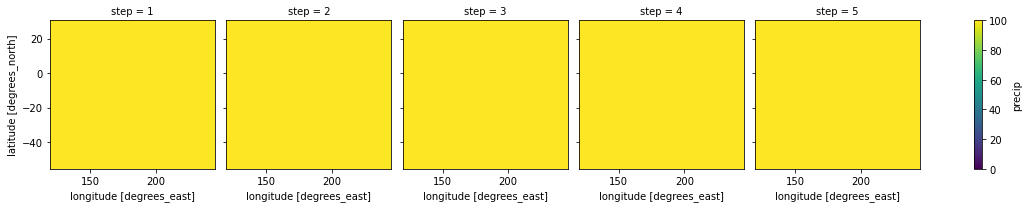

In [25]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale (just in case)

In [26]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

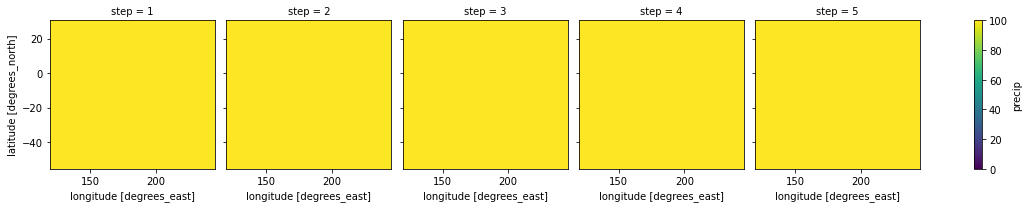

In [27]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### because the attributes are lost during these operations, we add them back 

In [28]:
probs_mean.attrs = probs.attrs

### Probability for being below a given percentile

#### choose the percentile here 

In [29]:
pmax = 25

### get the percentile bins edges, and select the category (starting at 1) that corresponds to the bin with right edge at `pmax`

In [30]:
max_cat = np.digitize(pmax/100, probs_mean.attrs['pct_values'])

In [31]:
max_cat

6

In [32]:
print(" | ".join(map(str, probs_mean.attrs['pct_values'].tolist()))) 

0.02 | 0.05 | 0.1 | 0.15 | 0.2 | 0.25 | 0.3 | 0.35 | 0.4 | 0.45 | 0.5 | 0.55 | 0.6 | 0.65 | 0.7 | 0.75 | 0.8 | 0.85 | 0.9 | 0.95


### plots the probabilities 

In [33]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

In [34]:
domain = domains.domains['Water_Watch']

### quick plot 

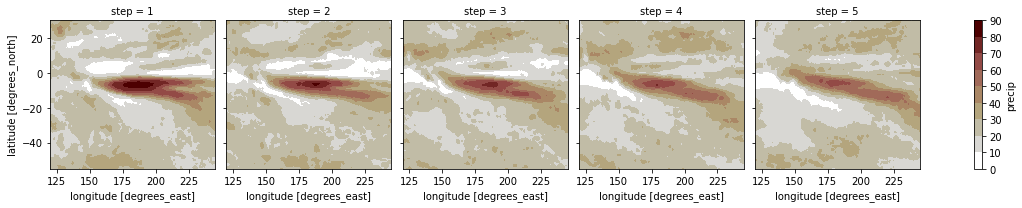

In [35]:
_ = probs_mean.sel({quantile:slice(None, max_cat)}).sum(quantile)[varname].squeeze().plot.contourf(col='step', levels=10, cmap=cmap)

### plot the probabilities for rainfall being below the climatological 25th percentile, for the next 3 months period  

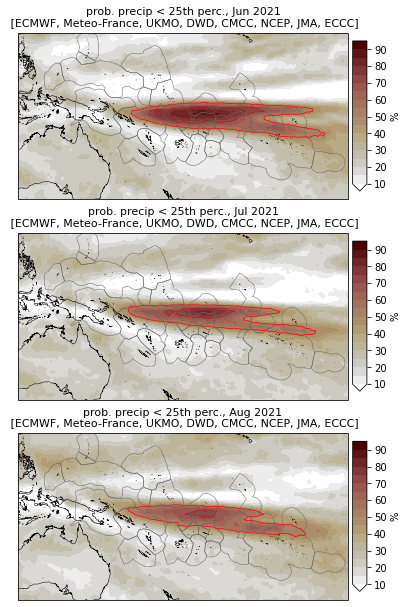

In [36]:
f = plot.map_MME_probabilities(probs_mean, nsteps=3, pct=pmax, domain=domain, shape=EEZs, pct_dim=quantile)

### probability for rainfall accumulation being below the median (50th percentile), for the next 5 months period

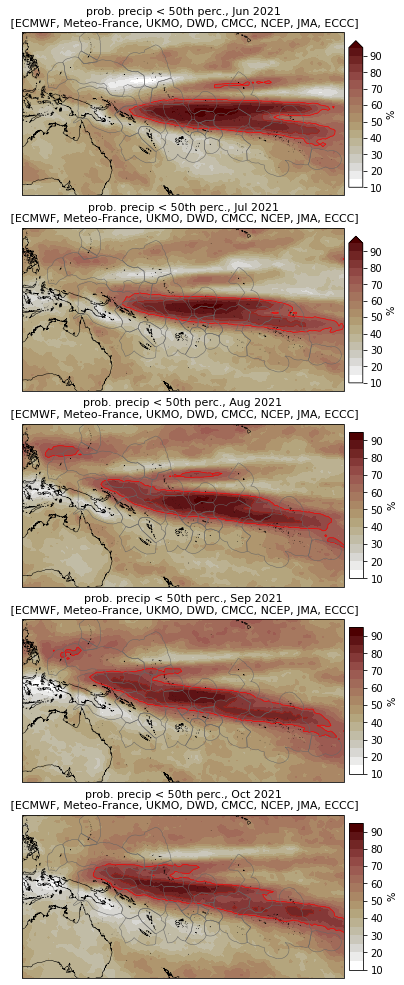

In [37]:
f = plot.map_MME_probabilities(probs_mean, nsteps=5, pct=50, domain=domain, shape=EEZs, pct_dim=quantile, contours=[70, 80])

### probability for rainfall accumulation being above the median (50th percentile)

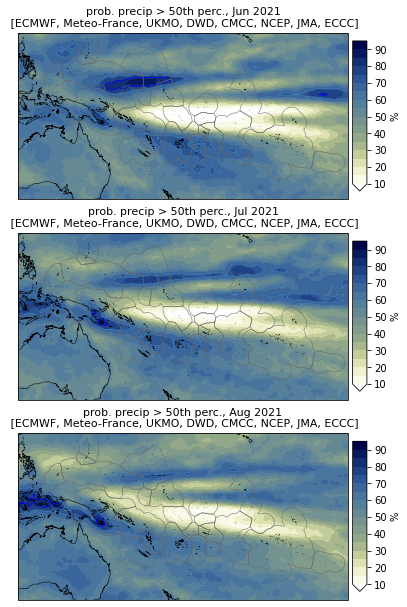

In [38]:
f = plot.map_MME_probabilities(probs_mean, nsteps=3, pct=50, comp='above', domain=domain, shape=EEZs, pct_dim=quantile, contours=[70, 80],  contours_colors=['steelblue', 'b'])

### probability for rainfall accumulation being above the 70th percentile

#### note that if the contours passed to the function are over the maximum, some defaults are used 

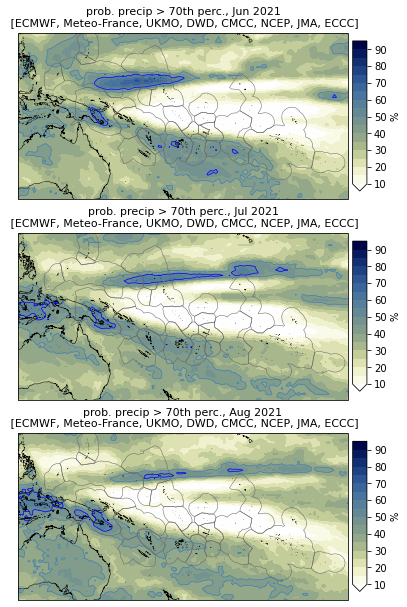

In [39]:
f = plot.map_MME_probabilities(probs_mean, nsteps=3, pct=70, comp='above', domain=domain, shape=EEZs, contours=[70, 80], contours_colors=['steelblue', 'b'])

### we can also insert a mask (from a geopandas dataframe) and apply it

<AxesSubplot:>

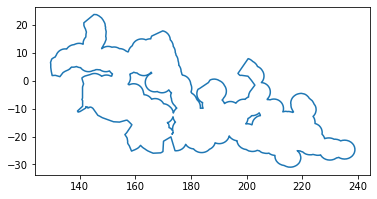

In [40]:
merged_EEZs.boundary.plot()

In [41]:
probs_mean_masked  = geo.make_mask_from_gpd(probs_mean, merged_EEZs, insert=True, mask_name='mask')

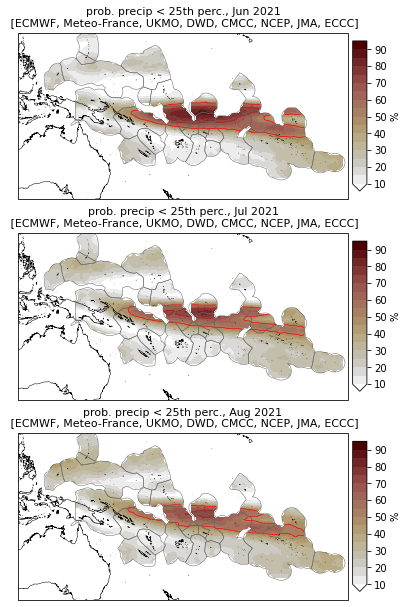

In [42]:
f = plot.map_MME_probabilities(probs_mean_masked, nsteps=3, pct=pmax, shape=EEZs, domain=domain, pct_dim=quantile, mask='mask')